## Vilnius real estate used Apartment market analysis

* Purpose: analyse Vilnius real estate pricing changes during Covid-19 and post-Covid period (est. 2020.05-2020.08)
* Hypothesis: The uncertainty brought by Covid-19 should bring fluctuations in Vilnius real estate selling and renting markets.
* Predictions:
  * 1. Increase in supply for apartments selling due to short-term rent demand drop.
  * 2. Decrease in prices due to plummeting demand and increase of supply due to point one.

* Scope: data from one of main the Lithuanian real estate market portals used.
* Data loaded weekly to monitor market changes.
* New apartments (year > 2019) are excluded from analysis as only partial data of their full supply and pricing are  available.
### Weak points
* The apartments being sold data is available from April. A better picture would have been having the data from as early as January.
* The apartments being rented data is available from May. A better picture would also require early data, such as start of 2020.
* Spikes in weeks' data possible. Preferred way would be to load data daily and smooth out edges with weekly averages. Daily scrapping is not possible however.
* There exists a practice of same apartment postings in multiple districts, that contributes to duplicate data. This duplicate data for the moment remains in dataset to support analysis splitting data into districts. 
* More sources could be included for analysis. This however can also result in duplicates.


In [2]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
from toai.imports import *
%matplotlib notebook
import data_prep
#import REP_Functions as rf

In [4]:
#load the raw data:
df_raw = pd.read_excel(r'C:\Users\tiesi\Class D\Real Estate Analysis Project\Data.xlsx', index_col=0) 
#remove data from new apartments:
df_raw = df_raw[df_raw['year']< 2019]
#remove data from exceptionally big apartments(projects):
df_raw = df_raw[df_raw['space_sq_m']< 120]
#keep only selling apartments (type = 1)  data:
df_raw = df_raw[df_raw['type'] == 1]
#update column types:
df_raw['log_date'] = pd.to_datetime(df_raw['log_date'])

Working the outlayers
* Quantiles will be calculated individually for each day when the data was collected.
* Bottom 5 and top 5 % of the data will be removed from each day to improve quality of results.

In [9]:
#getting all the dates
log_dates = set(df_raw['log_date'])
#print(sorted(log_dates))

#creating an analysis table where data without outlyers will be put
#df = pd.DataFrame(data=None, columns=df_raw.columns) #, index=df_raw.index 
df = df_raw[0:1].copy()
df = df.reset_index()
df = df.drop(df.index[0])

#preparing the quantiles range dataframe
column_names = ['Q1','Q2','Q3','Q4','IQR', 
                'Skewness_w_outlyers','Skewness', 
                'Mean_w_outlyers', 'Mean',
                'Median_w_outlyers', 'Median',
                'nr_objects_w_outlyers', 'nr_objects']
quantiles_range = pd.DataFrame(columns = column_names)

for date in sorted(log_dates):
    Q1 = df_raw['price_sq_m'][df_raw['log_date'] == date].quantile(.05) 
    Q2 = df_raw['price_sq_m'][df_raw['log_date'] == date].quantile(.25) 
    Q3 = df_raw['price_sq_m'][df_raw['log_date'] == date].quantile(.75) 
    Q4 = df_raw['price_sq_m'][df_raw['log_date'] == date].quantile(.95)
    Skewness1 = df_raw['price_sq_m'][df_raw['log_date'] == date].skew()
    Mean1 = df_raw['price_sq_m'][df_raw['log_date'] == date].mean()
    Median1 = df_raw['price_sq_m'][df_raw['log_date'] == date].median()
    IQR = Q3 - Q2
    df_temp = df_raw[df_raw['log_date'] == date]
    df_temp = df_temp[(df_temp['price_sq_m'] > Q1 - 1.25 * IQR)]
    df_temp = df_temp[(df_temp['price_sq_m'] < Q3 + 1.25 * IQR)]
    df = df.append(df_temp, sort=False)
    
    #df_temp = df_raw[df_raw['log_date'] == date][(df_raw['price_sq_m'] > Q1 - 1.5 * IQR) & (df_raw['price_sq_m'] < Q3 + 1.5 * IQR)]
    #df.append(df_temp)
    #df = df_raw[~((df_raw < (Q1 - 1.5 * IQR)) |(df_raw > (Q3 + 1.5 * IQR))).any(axis=1)]
    #adding data without outlyers to new table
#df = df_raw[df_raw['log_date'] == date][(df_raw['price_sq_m'] > Q1 - 1.5 * IQR) & (df_raw['price_sq_m'] < Q3 + 1.5 * IQR)]
    #df = df_raw[df_raw['log_date'] == date][df_raw['price_sq_m'] < Q3 + 1.5 * IQR]
#     df = df_raw[df_raw['price_sq_m'] > Q1]
#     df = df_raw[df_raw['price_sq_m'] < Q4]
    Skewness2 = df['price_sq_m'][df['log_date'] == date].skew()
    Mean2 = df['price_sq_m'][df['log_date'] == date].mean()
    Median2 = df['price_sq_m'][df['log_date'] == date].median()
    nr_objects_w_outlyers = df_raw['price_sq_m'][df_raw['log_date'] == date].count()
    nr_objects = df['price_sq_m'][df['log_date'] == date].count()
    quantiles_range = quantiles_range.append(pd.Series(data={'Q1': Q1,
                                                             'Q2': Q2,
                                                             'Q3' : Q3,
                                                             'Q4': Q4,
                                                             'IQR': IQR,
                                                             'Skewness_w_outlyers': Skewness1,
                                                             'Skewness': Skewness2,
                                                             'Mean_w_outlyers': Mean1,
                                                             'Mean': Mean2,
                                                             'Median_w_outlyers':Median1,
                                                             'Median':Median2,
                                                             'nr_objects_w_outlyers': nr_objects_w_outlyers,
                                                             'nr_objects': nr_objects
                                                            }, name=(date)))


In [10]:
quantiles_range['log_date'] = quantiles_range.index
quantiles_range.tail()

,Q1,Q2,Q3,Q4,IQR,Skewness_w_outlyers,Skewness,Mean_w_outlyers,Mean,Median_w_outlyers,Median,nr_objects_w_outlyers,nr_objects,log_date
2020-06-03,880.25,1327.75,2338.00,3497.0,1010.25,1.273209,0.554489,1908.496289,1797.483244,1714.0,1669.0,2156.0,2059.0,2020-06-03
2020-06-10,895.90,1331.00,2348.00,3528.8,1017.00,1.255566,0.577002,1922.711904,1810.067508,1724.0,1681.0,2159.0,2059.0,2020-06-10
2020-06-17,894.40,1328.00,2343.00,3575.4,1015.00,1.216751,0.581215,1920.561428,1805.302337,1721.0,1675.5,2157.0,2054.0,2020-06-17
2020-06-24,895.15,1325.00,2360.25,3548.8,1035.25,1.151173,0.593635,1923.802731,1816.904973,1721.5,1684.0,2124.0,2031.0,2020-06-24
2020-07-02,911.00,1332.00,2370.00,3557.5,1038.00,1.133216,0.584315,1930.981560,1825.029674,1728.0,1692.0,2115.0,2022.0,2020-07-02


## Creation of data buckets for further analysis
* 3 Different apartment size buckets will be investigated:
  * < ~46 square meters. Small apartment category.
  * 45 to 66 square meters. Medium apartment category.
  * 66 to 120 square meters. Large apartment category.
* Categorization built based on Quantile-based discretization function towards three splits.

In [11]:
df['size_bucket'] = pd.qcut(df['space_sq_m'], q=3, labels=["small", "medium", "large"])
df.groupby('size_bucket').aggregate(np.mean)

,ID,is_new_project,reserved,price_change,is_auction,nr_stars,year,total_price,price_sq_m,rounded_price_sq_m,nr_rooms,space_sq_m,rounded_space_sq_m,floor,nr_floors,state,type
size_bucket,,,,,,,,,,,,,,,,,
small,NaN,0.904035,0.904716,-0.008439,0.910406,0.393797,1976.515727,55582.337180,1694.918580,1696.301639,1.396843,32.305682,32.320511,3.160436,5.177585,1.835156,1.0
medium,NaN,0.910633,0.913963,0.149783,0.911676,0.488869,1987.454735,102891.114275,1834.515904,1837.126469,2.359953,56.180332,56.172075,3.572500,6.091653,1.918776,1.0
large,NaN,0.903815,0.904938,-0.004850,0.905178,0.360956,1989.456179,162684.250451,1923.335005,1924.692150,3.200915,83.567996,83.574345,3.487024,5.762866,1.865469,1.0


#### Average prices per apartment size

<Figure size 720x720 with 0 Axes>

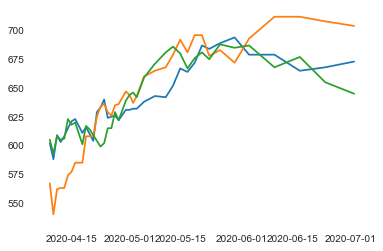

<Figure size 720x720 with 0 Axes>

In [12]:
#df_small_app = df[df['size_bucket']=='9.999, 45.84'] 
size_bucket_data = df.groupby(['size_bucket', 'log_date'])['price_sq_m'].agg(['mean', 'count'])
size_bucket_data = size_bucket_data.reset_index(level=['size_bucket', 'log_date'])
size_bucket_data = size_bucket_data.set_index('log_date')
size_bucket_data.head()
size_bucket_data2 = size_bucket_data[size_bucket_data['size_bucket'] == 'large']
size_bucket_data2
plt.plot(size_bucket_data[size_bucket_data['size_bucket'] == 'large']['count'])
plt.plot(size_bucket_data[size_bucket_data['size_bucket'] == 'medium']['count'])
plt.plot(size_bucket_data[size_bucket_data['size_bucket'] == 'small']['count'])
plt.figure(figsize=(10,10))
#plt.ylabel('Mean')
#axes = plt.gca()
#axes.set_xlim([0,2500])
#axes.set_ylim([0,700])

#plt.show()

## District & street Rankings

In [13]:
#street ranking calculation
streets = df.groupby('street')['price_sq_m'].agg(['mean'])
streets['street_rank'] = pd.qcut(streets['mean'], q=10)
#district ranking calculation
districts = df.groupby('district')['price_sq_m'].agg(['mean'])
districts['district_rank'] = pd.qcut(districts['mean'], q=10)
                               
df = pd.merge(df, districts['district_rank'], on='district', how='outer')
df = pd.merge(df, streets['street_rank'], on='street', how='outer')
df.head()

,ID,log_date,district,street,is_new_project,reserved,price_change,is_auction,nr_stars,year,...,nr_rooms,space_sq_m,rounded_space_sq_m,floor,nr_floors,state,type,size_bucket,district_rank,street_rank
0,NaN,2020-04-09,Antakalnis,Ajerų g.,0,0,0.0,0,0,2018,...,4,113.69,114,1,2,1,1,large,"(1960.425, 2069.666]","(1023.0, 1253.783]"
1,NaN,2020-04-10,Antakalnis,Ajerų g.,0,0,0.0,0,0,2018,...,4,113.69,114,1,2,1,1,large,"(1960.425, 2069.666]","(1023.0, 1253.783]"
2,NaN,2020-04-11,Antakalnis,Ajerų g.,0,0,0.0,0,0,2018,...,4,113.69,114,1,2,1,1,large,"(1960.425, 2069.666]","(1023.0, 1253.783]"
3,NaN,2020-04-12,Antakalnis,Ajerų g.,0,0,0.0,0,0,2018,...,4,113.69,114,1,2,1,1,large,"(1960.425, 2069.666]","(1023.0, 1253.783]"
4,NaN,2020-04-13,Antakalnis,Ajerų g.,1,1,0.0,1,0,2018,...,4,113.69,114,1,2,1,1,large,"(1960.425, 2069.666]","(1023.0, 1253.783]"


# Map work

In [14]:
import geopandas as gpd
import osmnx as ox
import networkx

Vilnius_map = "Vilnius,Lithuania"
graph = ox.graph_from_place(Vilnius_map)
networkx.classes.multidigraph.MultiDiGraph

nodes , streets_gdf = ox.graph_to_gdfs(graph)

In [15]:
streets_gdf2 = pd.DataFrame(streets_gdf)
streets_gdf2['street'] = streets_gdf2['name'].astype('str')
streets2 = streets2 = streets.iloc[:,:0]

streets_gdf2 = pd.merge(streets_gdf2, streets2, how='inner', left_on='street', right_on='street')
#streets_gdf2 = streets_gdf2[streets_gdf2['mean'].notnull()]
streets_gdf = gpd.GeoDataFrame(streets_gdf2, geometry='geometry')
streets_gdf = streets_gdf.reset_index()
distinct_streets = streets_gdf.groupby('name').index.agg(['min'])
streets_gdf = pd.merge(streets_gdf, distinct_streets, how='inner', left_on='index', right_on='min')

In [16]:
def coord_lister(geom):
    coords = list(geom.coords)
    return (coords)

coordinates = streets_gdf.geometry.apply(coord_lister)

In [17]:
coordinates2 = {}
for items in coordinates.iteritems():
    coordinates2[items[0]] = [items[1][0][1],items[1][0][0]]
    
coordinates_list = [(v) for v in coordinates2.values()]  

In [59]:
#streets_gdf.shape
#test25 = streets_gdf2.groupby(['name']).size
#test25
#streets_gdf[streets_gdf['mean'].notnull()]
#type(streets_gdf)
#streets_gdf_temp = streets_gdf.loc[0:100]
#streets_gdf_temp = streets_gdf[streets_gdf['mean'].isnull()]
#streets_gdf_temp
#gjson = streets_gdf_temp.to_crs(epsg='4326')
#gjson = gjson.to_json()

In [18]:
#type(streets_gdf_temp.geometry)
#streets_gdf_temp.head()
points_a = [[54.70393 ,25.31724],[54.704323,25.310023]]
points_a = coordinates_list  

In [19]:
def call_hi():
    return 'got you fucker'

def get_colour():
    return 'red'

In [20]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

In [18]:
#import folium
mapa = folium.Map() 
mapa = folium.Map([54.70393 ,25.31724],
                  zoom_start=10)
                  #tiles='cartodbpositron')

#points = folium.features.GeoJson(gjson)
for each in points_a:  
    mapa.add_child(folium.CircleMarker(location=each,
    fill='true',
    radius = 4,
    popup= call_hi(),
    fill_color= get_colour(),
    color = 'clear',
    fill_opacity=1))
    
#mapa.add_children(points)
mapa

In [13]:
m = folium.Map()
folium.Choropleth(world, data=streets_gdf, 
                  key_on='feature.properties.name',
                  columns=['name', 'pop_est'], 
                  fill_color='YlOrBr').add_to(m)

folium.LayerControl().add_to(m)

m

NameError: name 'world' is not defined